In [1]:
# Main library: https://square.github.io/pysurvival/index.html
#----------------------------Reproducible------------------------------------------
import numpy as np
import random as rn
import pandas as pd
import gc
import os

seed=0
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
rn.seed(seed)

#----------------------------Reproducible------------------------------------------

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from sklearn.model_selection import train_test_split
from pysurvival.models.semi_parametric import NonLinearCoxPHModel
from pysurvival.utils.metrics import concordance_index
from pysurvival.utils.display import integrated_brier_score
from pysurvival.utils.display import display_loss_values
from pysurvival.utils.display import compare_to_actual

from lifelines import KaplanMeierFitter
from matplotlib import pyplot as plt

import heapq
import seaborn as sns

In [2]:
def csv_read(p_path):
    pd_data=pd.read_csv(p_path, sep=',')
    column_names=pd_data.columns.values.tolist()
    print(column_names)
    return pd_data,column_names

def write_to_csv(p_data,p_path):
    dataframe = pd.DataFrame(p_data)
    dataframe.to_csv(p_path, mode='a',header=False,index=False,sep=',')
    del dataframe
    gc.collect()

In [3]:
data,column_names=csv_read('./data/survival_data_filtered_3.csv')

['NACCREAS', 'NACCREFR', 'BIRTHMO', 'BIRTHYR', 'SEX', 'HISPANIC', 'HISPOR', 'RACE', 'RACESEC', 'RACETER', 'PRIMLANG', 'EDUC', 'MARISTAT', 'NACCLIVS', 'INDEPEND', 'RESIDENC', 'HANDED', 'NACCFADM', 'NACCFFTD', 'MEMORY', 'ORIENT', 'JUDGMENT', 'COMMUN', 'HOMEHOBB', 'PERSCARE', 'CDRSUM', 'DECSUB', 'DECIN', 'COGMEM', 'COGJUDG', 'COGLANG', 'COGVIS', 'COGATTN', 'COGOTHR', 'NACCCOGF', 'COGMODE', 'DECAGE', 'BEAPATHY', 'BEDEP', 'BEVHALL', 'BEAHALL', 'BEDEL', 'BEDISIN', 'BEIRRIT', 'BEAGIT', 'BEPERCH', 'BEOTHR', 'NACCBEHF', 'BEMODE', 'MOGAIT', 'MOFALLS', 'MOTREM', 'MOSLOW', 'NACCMOTF', 'MOMODE', 'COURSE', 'FRSTCHG', 'NORMCOG', 'DEMENTED', 'NACCPPA', 'NACCBVFT', 'NACCLBDS', 'NACCTMCI', 'NACCMCIL', 'NACCMCIA', 'NACCMCIE', 'NACCMCIV', 'NACCMCII', 'IMPNOMCI', 'NACCALZD', 'NACCALZP', 'NACCLBDE', 'NACCLBDP', 'PARK', 'PSP', 'PSPIF', 'CORT', 'CORTIF', 'DOWNS', 'DOWNSIF', 'HUNT', 'HUNTIF', 'PRION', 'PRIONIF', 'BRNINJ', 'BRNINJIF', 'HYCEPH', 'HYCEPHIF', 'NEOP', 'NEOPIF', 'DEP', 'DEPIF', 'OTHPSY', 'OTHPSYIF',

In [4]:
data

,NACCREAS,NACCREFR,BIRTHMO,BIRTHYR,SEX,HISPANIC,HISPOR,RACE,RACESEC,RACETER,...,NPBNKB,NACCFORM,NACCPARA,NACCCSFP,NPBNKF,NPFAUT,NACCDAGE,NACCINT,SurvivalTime,Event
0,2,2,10,1946,2,0,88,1,88,88,...,1,1,1,0,0,0,72,33,891,True
1,1,8,5,1931,1,0,88,1,88,88,...,0,1,1,0,0,0,88,43,1304,True
2,2,2,1,1924,2,0,88,1,88,88,...,1,1,1,0,0,0,90,67,702,True
3,1,2,9,1934,2,0,88,1,88,88,...,1,1,1,1,1,0,84,4,379,True
4,1,8,10,1942,2,0,88,1,88,88,...,0,1,1,1,0,0,76,53,1099,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,1,1,11,1938,2,0,88,1,88,88,...,1,1,1,0,0,0,76,2,2733,True
348,1,1,5,1951,1,0,88,1,88,88,...,0,1,1,1,0,0,68,36,2539,False
349,1,2,5,1954,2,0,88,1,88,88,...,1,1,1,0,0,0,66,91,1127,False
350,2,2,7,1924,2,0,88,1,3,88,...,1,1,1,0,0,0,96,3,417,True


In [5]:
Events=np.array(data.loc[:,'Event'])
print("%.2f%% samples are right censored in whole data." % (np.sum(~Events) * 100. / len(Events)))

38.92% samples are right censored in whole data.


In [6]:
X=data.loc[:,'NACCREAS':'NACCINT']
y_=data.loc[:,'SurvivalTime':'Event']
y=np.array([(y__[1],y__[0]) for y__ in np.array(y_)], dtype=[('Event', 'bool'), ('SurvivalTime', '<f8')])

models=[]
structure = [ {'activation': 'BentIdentity', 'num_units': 150},  ]
seed_num=5
epoch_num=2000

for seed_i in [3]:

    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2, random_state=seed_i)

    time_train=y_train['SurvivalTime']
    event_train=y_train['Event']
    time_test=y_test['SurvivalTime']
    event_test=y_test['Event']

    # Building the model
    nonlinear_coxph = NonLinearCoxPHModel(structure=structure)
    nonlinear_coxph.fit(X_train, time_train, event_train, num_epochs = epoch_num,lr=1e-4, init_method='glorot_uniform')

    models.append(nonlinear_coxph)

% Completion: 100%|***********************************************|Loss: 554.07


C-index: 0.75


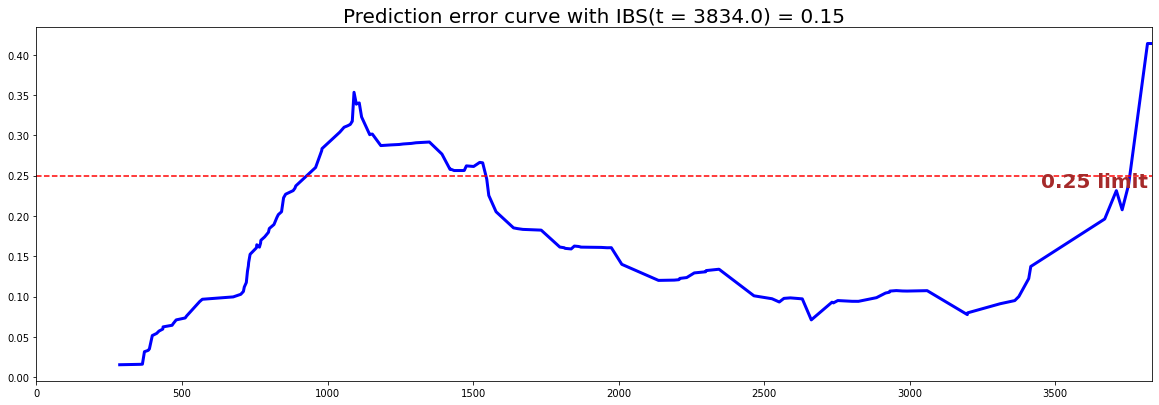

IBS: 0.15


In [7]:
# Model Performances
c_index = concordance_index(models[0], X_test, time_test, event_test) #0.81
print('C-index: {:.2f}'.format(c_index))

ibs = integrated_brier_score(models[0], X_test, time_test, event_test, t_max=None, figure_size=(20, 6.5) )
print('IBS: {:.2f}'.format(ibs))

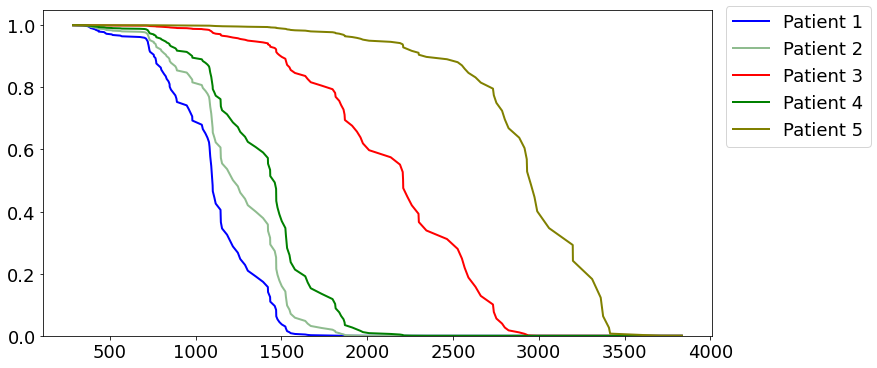

In [8]:
cs=['blue','darkseagreen','red','green','olive','cyan','tan','silver','purple','fuchsia','chocolate','darkcyan','aqua','pink','orange','bisque','lightsteelblue']

np.random.seed(2)
# Randomly extracting a data-point that experienced an event 
choices = np.argwhere((event_test==1.)&(time_test>=1)).flatten()
k_list = np.random.choice( choices, 5,replace=False)


fig, ax = plt.subplots(figsize=(12, 6))
    
# Saving the time of event
for i in np.arange(len(k_list)):
    k=k_list[i]
    t = time_test[k]

    # Computing the Survival function for all times t
    predicted = models[0].predict_survival(X_test.values[k, :]).flatten()

    # Displaying the functions
    plt.plot(models[0].times, predicted, color=cs[i], label='Patient '+str(i+1), lw=2)
    
      
plt.legend(loc=[1.02,0.58],fontsize=18, ncol=1)
plt.ylim(0, 1.05)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

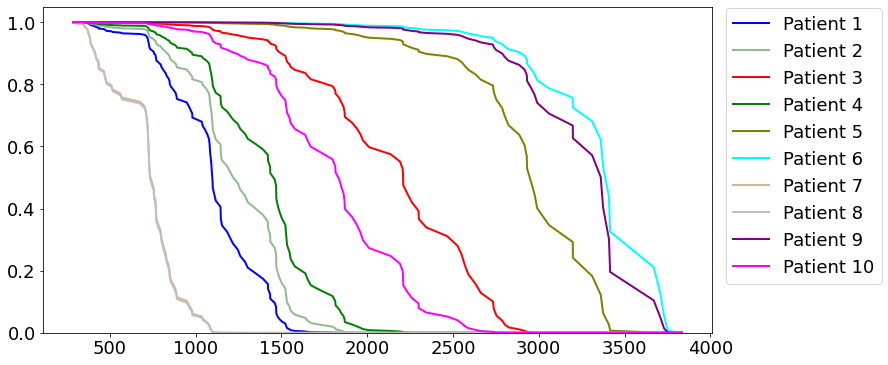

In [9]:
np.random.seed(2)
# Randomly extracting a data-point that experienced an event 
choices = np.argwhere((event_test==1.)&(time_test>=1)).flatten()
k_list = np.random.choice( choices, 10,replace=False)


fig, ax = plt.subplots(figsize=(12, 6))
    
# Saving the time of event
for i in np.arange(len(k_list)):
    k=k_list[i]
    t = time_test[k]

    # Computing the Survival function for all times t
    predicted = models[0].predict_survival(X_test.values[k, :]).flatten()

    # Displaying the functions
    plt.plot(models[0].times, predicted, color=cs[i], label='Patient '+str(i+1), lw=2)
    
      
plt.legend(loc=[1.02,0.15],fontsize=18, ncol=1)
plt.ylim(0, 1.05)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

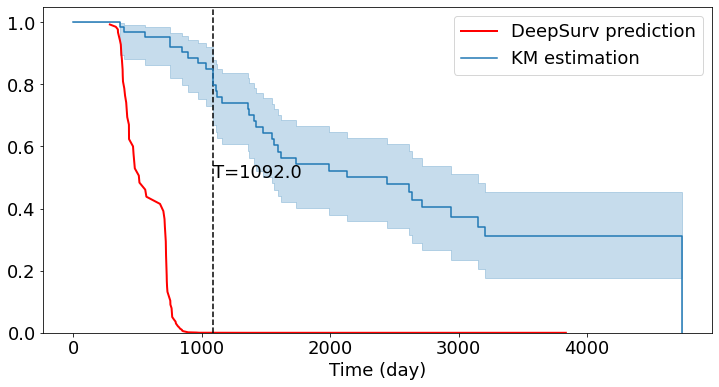

In [26]:
np.random.seed(3)

# Randomly extracting a data-point that experienced an event 
choices = np.argwhere((event_test==1.)&(time_test>=1)).flatten()
k = np.random.choice( choices, 1)[0]
        
kmf = KaplanMeierFitter()
fig, ax = plt.subplots(figsize=(12, 6))

# Saving the time of event
t = time_test[k]

# Computing the Survival function for all times t
predicted = models[0].predict_survival(X_test.values[k, :]).flatten()

# Displaying the functions
plt.plot(models[0].times, predicted, color='red', label='DeepSurv prediction', lw=2)

# Actual time
plt.axvline(x=t, color='black', ls ='--')
ax.annotate('T={:.1f}'.format(t), xy=(t, 0.5), xytext=(t, 0.5), fontsize=18)

kmf.fit(time_test, event_observed=event_test)
ax = kmf.plot_survival_function(ax=ax,label="KM estimation")

# Show everything
plt.legend(fontsize=18)
plt.ylim(0, 1.05)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Time (day)',fontsize=18)
plt.show()

In [11]:
threshold=0.05
km_index=np.where(np.array(kmf.survival_function_)[:,0]>=threshold)[0]

In [12]:
np.dot(kmf.timeline[km_index],np.array(kmf.survival_function_)[:,0][km_index])/kmf.timeline[km_index].shape[0]

922.861392602904

In [13]:
np.abs(np.dot(kmf.timeline,np.array(kmf.survival_function_)[:,0])/kmf.timeline.shape[0]-t)

183.3364749756023

In [14]:
np.abs(np.dot(kmf.timeline,(1-np.array(kmf.survival_function_)[:,0]))/kmf.timeline.shape[0]-t)

131.0789096397823

In [15]:
kmf.timeline

array([   0.,  235.,  365.,  397.,  413.,  560.,  754.,  756.,  763.,
        764.,  783.,  798.,  844.,  845.,  895.,  974., 1033., 1064.,
       1089., 1090., 1092., 1113., 1123., 1127., 1135., 1161., 1173.,
       1363., 1369., 1406., 1425., 1474., 1540., 1548., 1561., 1595.,
       1617., 1735., 1949., 1989., 2129., 2365., 2441., 2484., 2539.,
       2581., 2616., 2636., 2714., 2781., 2898., 2933., 2937., 3149.,
       3208., 3317., 3345., 3463., 3550., 3610., 3711., 3907., 3984.,
       4571., 4737.])

In [16]:
kmf.survival_function_

,KM_estimate
timeline,
0.0,1.000000
235.0,1.000000
365.0,0.984615
397.0,0.968987
413.0,0.968987
...,...
3711.0,0.310534
3907.0,0.310534
3984.0,0.310534


In [17]:
deepsurv_index=np.where(predicted>threshold)[0]
np.dot(models[0].times[deepsurv_index],predicted[deepsurv_index]/models[0].times[deepsurv_index].shape[0])

246.7170815508084

In [18]:
np.where(kmf.timeline==t)

(array([20]),)

In [19]:
kmf_index=np.where(kmf.timeline==t)[0][0]
1-np.array(kmf.survival_function_)[:,0][kmf_index]

0.20382483194320822

In [20]:
models[0].times

array([ 286.,  332.,  348.,  349.,  356.,  364.,  371.,  373.,  375.,
        379.,  382.,  385.,  386.,  388.,  398.,  404.,  413.,  417.,
        421.,  434.,  435.,  466.,  470.,  475.,  480.,  511.,  516.,
        561.,  570.,  676.,  702.,  711.,  714.,  721.,  722.,  723.,
        725.,  728.,  729.,  731.,  734.,  756.,  757.,  766.,  770.,
        771.,  784.,  797.,  800.,  816.,  826.,  831.,  842.,  848.,
        849.,  856.,  882.,  888.,  891.,  948.,  959.,  980.,  981.,
       1036., 1042., 1057., 1069., 1078., 1081., 1083., 1085., 1091.,
       1099., 1100., 1109., 1117., 1145., 1146., 1147., 1154., 1183.,
       1217., 1246., 1260., 1288., 1304., 1350., 1393., 1421., 1422.,
       1434., 1435., 1461., 1469., 1470., 1477., 1488., 1502., 1523.,
       1526., 1533., 1547., 1554., 1579., 1639., 1653., 1671., 1734.,
       1798., 1813., 1816., 1837., 1848., 1862., 1868., 1870., 1912.,
       1940., 1961., 1975., 2011., 2137., 2191., 2207., 2209., 2210.,
       2234., 2260.,

In [21]:
t

1092.0

In [22]:
deepsurv_index=np.where(models[0].times>t)[0][0]
1-predicted[deepsurv_index]

0.9999999249604539

In [23]:
type(predicted)

numpy.ndarray